In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
import re

In [3]:
# Download stopwords
nltk.download('stopwords', quiet=True)

True

In [4]:
# Create sample data (in real scenario, you'd load from files)
structured_data = pd.DataFrame({
    'patient_id': range(1, 11),
    'age': [45, 36, 52, 29, 61, 38, 44, 57, 33, 42],
    'blood_pressure': [120, 115, 140, 125, 155, 118, 128, 145, 112, 130],
    'glucose': [85, 92, 110, 88, 130, 90, 98, 115, 84, 95],
    'cholesterol': [190, 175, 220, 165, 240, 180, 195, 215, np.nan, 200],
    'gender': ['M', 'F', 'M', 'F', 'M', 'F', 'M', 'F', 'M', 'F'],
    'diagnosis': ['Healthy', 'Healthy', 'Hypertension', 'Healthy', 'Diabetes',
                 'Healthy', 'Healthy', 'Hypertension', 'Healthy', 'Healthy']
})

unstructured_data = pd.DataFrame({
    'patient_id': range(1, 11),
    'clinical_notes': [
        "Patient presents with normal vitals. No complaints.",
        "Patient reports occasional headaches, but otherwise well.",
        "Patient has been experiencing elevated blood pressure.",
        "Patient in good health. Regular exercise maintained.",
        "Patient shows signs of diabetes. High blood sugar levels.",
        "Patient reports mild fatigue but all vitals normal.",
        "Patient recovering well from recent surgery.",
        "Patient's blood pressure remains high despite medication.",
        "Patient reports no health issues. All tests normal.",
        "Patient experiencing seasonal allergies."
    ]
})

Structured data cluster centers:
        age  blood_pressure   glucose  cholesterol
0  1.095389        1.033381  0.969502     0.924028
1 -0.563633       -0.577573 -0.591135    -0.546608
2  1.754651        1.976247  2.198943     1.978201

Unstructured data: Top terms per cluster
Cluster 0: blood, experiencing, patient, pressure, high
Cluster 1: vitals, normal, reports, patient, presents
Cluster 2: health, tests, issues, regular, good


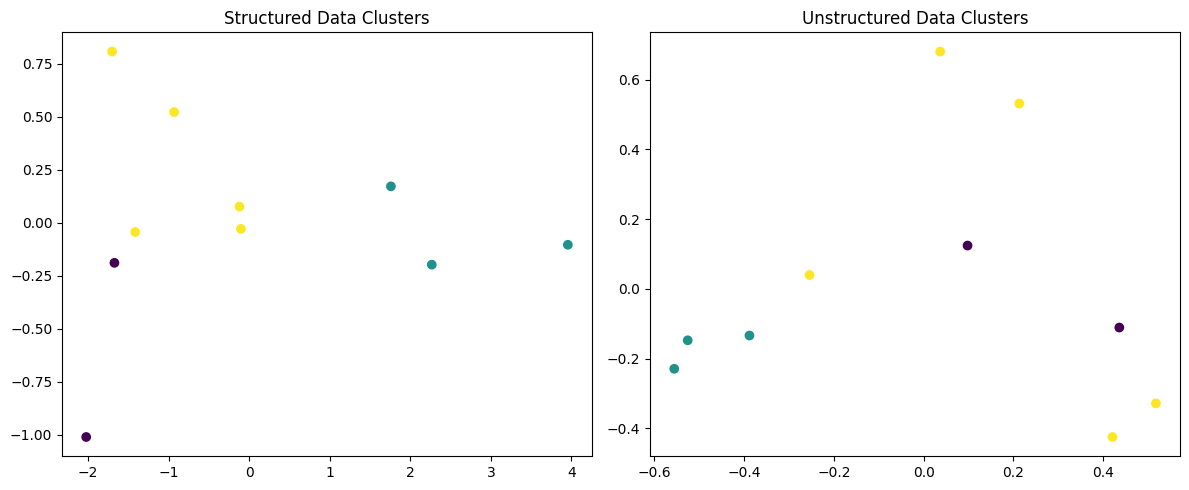

In [5]:
# Function for text preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    stop_words = set(stopwords.words('english'))
    return ' '.join([word for word in text.split() if word not in stop_words])

# Process structured data
structured_data['cholesterol'] = SimpleImputer(strategy='mean').fit_transform(structured_data[['cholesterol']])
structured_data_encoded = pd.get_dummies(structured_data, columns=['gender', 'diagnosis'])
features = ['age', 'blood_pressure', 'glucose', 'cholesterol']
X_scaled = StandardScaler().fit_transform(structured_data_encoded[features])

# Apply PCA and clustering to structured data
pca = PCA(n_components=2)
structured_pca = pca.fit_transform(X_scaled)
structured_clusters = KMeans(n_clusters=3, random_state=42).fit_predict(X_scaled)

# Process unstructured data
unstructured_data['processed_notes'] = unstructured_data['clinical_notes'].apply(preprocess_text)
tfidf = TfidfVectorizer(max_features=50).fit_transform(unstructured_data['processed_notes'])
text_clusters = KMeans(n_clusters=3, random_state=42).fit_predict(tfidf)

# Visualize results
plt.figure(figsize=(12, 5))

# Plot structured data clusters
plt.subplot(1, 2, 1)
plt.scatter(structured_pca[:, 0], structured_pca[:, 1], c=structured_clusters)
plt.title('Structured Data Clusters')

# Plot unstructured data clusters
text_pca = PCA(n_components=2).fit_transform(tfidf.toarray())
plt.subplot(1, 2, 2)
plt.scatter(text_pca[:, 0], text_pca[:, 1], c=text_clusters)
plt.title('Unstructured Data Clusters')

plt.tight_layout()
plt.savefig('clinical_data_clusters.png')

# Print summary of findings
print("Structured data cluster centers:")
cluster_centers = pd.DataFrame(
    KMeans(n_clusters=3).fit(X_scaled).cluster_centers_,
    columns=features
)
print(cluster_centers)

print("\nUnstructured data: Top terms per cluster")
feature_names = TfidfVectorizer(max_features=50).fit(unstructured_data['processed_notes']).get_feature_names_out()
kmeans_text = KMeans(n_clusters=3).fit(tfidf)
for i, center in enumerate(kmeans_text.cluster_centers_):
    top_indices = center.argsort()[-5:][::-1]
    print(f"Cluster {i}: {', '.join([feature_names[idx] for idx in top_indices])}")